In [1]:
import pandas as pd
import numpy as np
import os
import sys
from collections import Counter
import gget
import scipy
import scanpy as sc
from kneed import KneeLocator

from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import leidenalg

from Bio import SeqIO
from Bio.KEGG import REST
from Bio.KEGG.KGML import KGML_parser

import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

"""WARNING: disabling future warnings"""
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sys.path.append("../")
import utils as ut

In [2]:
# fpath = "/nfs/turbo/umms-indikar/shared/projects/HSC/data/single-cell/nov2023_run1/scanpy/anndata.h5ad"
# fpath = "/nfs/turbo/umms-indikar/shared/projects/HSC/data/single-cell/nov2023_run2/scanpy/anndata.h5ad"
# fpath = "/scratch/indikar_root/indikar1/cstansbu/all_scHSC/scanpy/anndata.h5ad"
# fpath = "/scratch/indikar_root/indikar1/cstansbu/all_scHSC_run3/scanpy/anndata.h5ad"
# fpath = "/scratch/indikar_root/indikar1/cstansbu/all_scHSC_run4/scanpy/anndata.h5ad"
# fpath = "/scratch/indikar_root/indikar1/cstansbu/all_HSC/scanpy/anndata.h5ad"
fpath = "/scratch/indikar_root/indikar1/cstansbu/all_HSC/scanpy/anndata_distance.h5ad"

adata = sc.read(fpath, cache=False)
adata.X = adata.layers["counts"]
adata

AnnData object with n_obs × n_vars = 8475 × 14753
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'clusters', 'cluster_name', 'UMAP 1', 'UMAP 2', 'Fibroblast_mean', 'Fibroblast_max', 'Fibroblast_argmax', 'Fibroblast_highest_exp', 'HSC_mean', 'HSC_max', 'HSC_argmax', 'HSC_highest_exp'
    var: 'gene_name', 'Chromosome', 'Start', 'End', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cluster_name_colors', 'clusters_colors', 'clusters_sizes', 'dendrogram_cluster_name', 'hvg', 'leiden', 'log1p', 'neighbors', 'paga', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

# load marker gene sets from pangloaDB

In [3]:
def getGenes(pdf, cellType, ui_upper=None):
    genes = pdf[pdf['cell type'] == cellType]
    if not ui_upper is None:
        genes = genes[genes['ubiquitousness index'] < ui_upper]
    return genes['official gene symbol'].to_list()

pdfPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/panglaodb/pandb.tsv.gz"
pandDf = pd.read_csv(pdfPath, sep="\t")

fb = getGenes(pandDf, 'Fibroblasts')
hsc = getGenes(pandDf, 'Hematopoietic stem cells')

print(f"FB genes: {len(fb)}")
print(f"HP genes: {len(hsc)}")

all_markers = list(set(fb + hsc))
# filter out genes not expressed
all_markers = [x for x in all_markers if x in adata.var['gene_name'].to_list()]
print(f"Union: {len(all_markers)}")

FB genes: 179
HP genes: 88
Union: 203


In [4]:
genes = adata.var.copy()
genes = genes[genes['gene_name'].isin(all_markers)]
print(f"{genes.shape=}")
genes.head()

genes.shape=(203, 15)


,gene_name,Chromosome,Start,End,Strand,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,means,dispersions,dispersions_norm
gene_id,,,,,,,,,,,,,,,
ENSG00000028137,TNFRSF1B,1,12166990,12209228,+,1481,False,1481,0.201888,82.525074,1711,True,0.378643,1.321751,0.777260
ENSG00000116132,PRRX1,1,170662727,170739421,+,42,False,42,0.004956,99.504425,42,False,0.010225,0.930643,-0.673327
ENSG00000150681,RGS18,1,192158461,192185815,+,414,False,414,0.057699,95.115044,489,False,0.110433,1.080202,-0.123114
ENSG00000092969,TGFB2,1,218345335,218444619,+,41,False,41,0.004838,99.516224,41,False,0.009768,0.874292,-0.880635
ENSG00000116690,PRG4,1,186296278,186314567,+,203,False,203,0.024897,97.604720,211,False,0.050956,0.969692,-0.529670


In [5]:
pdf = adata[:, genes.index.to_list()].copy()
pdf

AnnData object with n_obs × n_vars = 8475 × 203
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'clusters', 'cluster_name', 'UMAP 1', 'UMAP 2', 'Fibroblast_mean', 'Fibroblast_max', 'Fibroblast_argmax', 'Fibroblast_highest_exp', 'HSC_mean', 'HSC_max', 'HSC_argmax', 'HSC_highest_exp'
    var: 'gene_name', 'Chromosome', 'Start', 'End', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cluster_name_colors', 'clusters_colors', 'clusters_sizes', 'dendrogram_cluster_name', 'hvg', 'leiden', 'log1p', 'neighbors', 'paga', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [13]:
subsample = sc.pp.subsample(pdf, fraction=0.25, copy=True)
print(subsample)
X = subsample.X

# plt.imshow(np.log1p(X))
# plt.yticks([])
# plt.xticks([])
# plt.ylabel("Cells")
# plt.xlabel("Genes")

AnnData object with n_obs × n_vars = 2118 × 203
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'clusters', 'cluster_name', 'UMAP 1', 'UMAP 2', 'Fibroblast_mean', 'Fibroblast_max', 'Fibroblast_argmax', 'Fibroblast_highest_exp', 'HSC_mean', 'HSC_max', 'HSC_argmax', 'HSC_highest_exp', 'cluster_labels'
    var: 'gene_name', 'Chromosome', 'Start', 'End', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cluster_name_colors', 'clusters_colors', 'clusters_sizes', 'dendrogram_cluster_name', 'hvg', 'leiden', 'log1p', 'neighbors', 'paga', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'


In [14]:
def cluster(X, knn=11, resolution=1.0):
    """A function to cluster a data matrix """
    # transform to adjacency graph 
    nbrs = NearestNeighbors(n_neighbors=knn, algorithm='ball_tree').fit(X)
    g = nbrs.kneighbors_graph(X).toarray()
    g = sc._utils.get_igraph_from_adjacency(g, directed=False)
    
    partition_type = leidenalg.RBConfigurationVertexPartition
    part = leidenalg.find_partition(g, partition_type, resolution_parameter=resolution)
    groups = np.array(part.membership)

    return groups

cluster_labels = cluster(pdf.X, resolution=0.1)
pdf.obs['cluster_labels'] = cluster_labels
pdf.obs['cluster_labels'] = pdf.obs['cluster_labels'].astype('category')
pdf.obs['cluster_labels'].value_counts()

0    2627
1    2262
2    1871
3    1715
Name: cluster_labels, dtype: int64

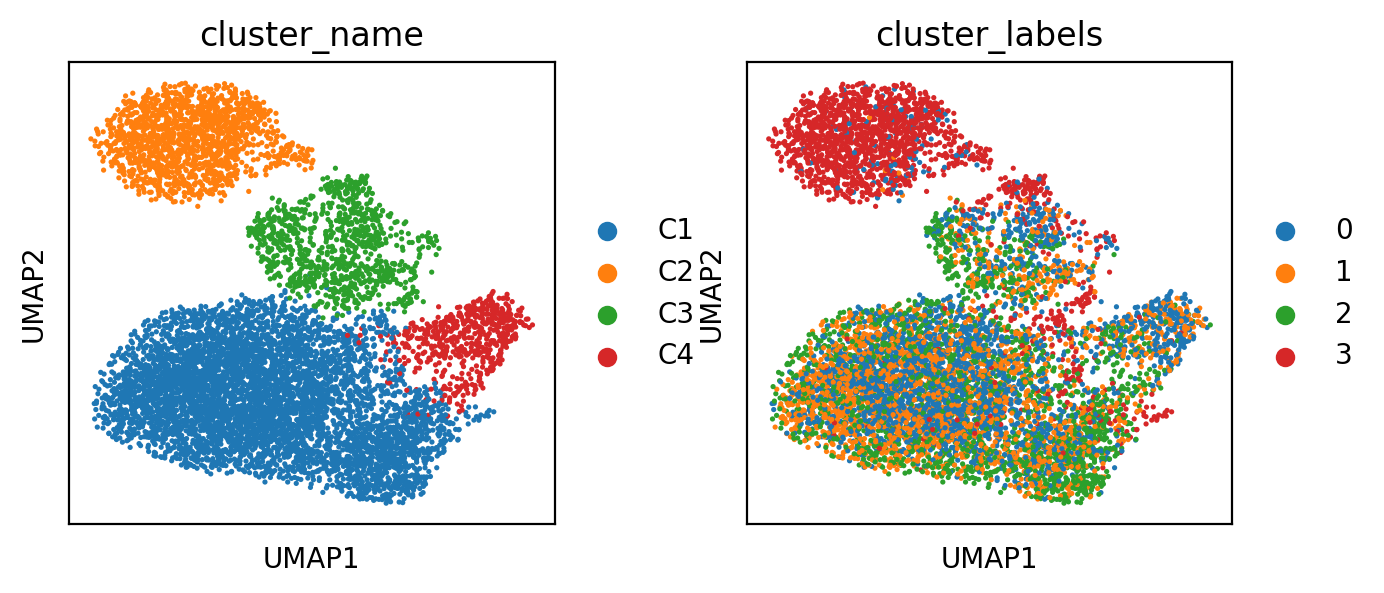

In [15]:

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3
sc.pl.umap(pdf, color=['cluster_name', 'cluster_labels'])

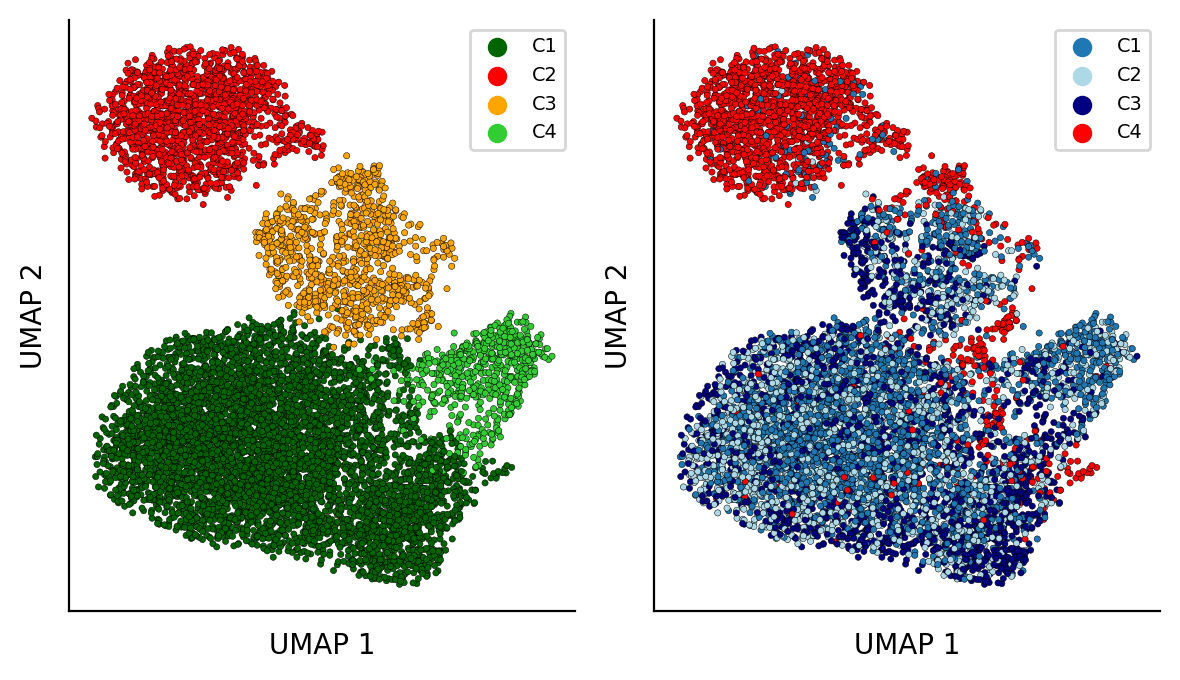

In [49]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 3.5
fig, axs = plt.subplots(1, 2)

colors = ['darkgreen', 'red', "orange", "limegreen"]
colors2 = ['C0', 'lightblue', "navy", "red"]

pdf.obs['cluster_label_names'] = pdf.obs['cluster_labels'].apply(lambda x: f"C{int(x) + 1}" )

sns.scatterplot(data=pdf.obs, 
                x='UMAP 1',
                y='UMAP 2',
                hue='cluster_name',
                ec='k',
                palette=colors,
                s=5,
                ax=axs[0])

axs[0].set_yticks([])
axs[0].set_xticks([])
sns.move_legend(axs[0],
                title="",
                fontsize='x-small',
                loc='upper right')


sns.scatterplot(data=pdf.obs, 
                x='UMAP 1',
                y='UMAP 2',
                hue='cluster_label_names',
                ec='k',
                palette=colors2,
                s=5,
                ax=axs[1])

sns.move_legend(axs[1],
                title="",
                fontsize='x-small',
                loc='upper right')

axs[1].set_yticks([])
axs[1].set_xticks([])
plt.tight_layout()
sns.despine()

In [37]:
?plt.axes.Axes.legend

Object `plt.axes.Axes.legend` not found.


In [9]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)